<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_08_auto_ml_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Tuning

In [0]:
COLAB = True 

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

In [0]:
# !pip install -U imblearn
# !pip install -U xgboost
# !pip install -U featuretools

In [5]:
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects

Cloning into 'dl-projects'...
remote: Enumerating objects: 1625, done.
remote: Total 1625 (delta 0), reused 0 (delta 0), pack-reused 1625
Receiving objects: 100% (1625/1625), 76.00 MiB | 28.05 MiB/s, done.
Resolving deltas: 100% (995/995), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

In [0]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys
import gc

from scipy import stats
from collections import Counter
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import featuretools as ft
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, make_scorer, recall_score, roc_curve, mean_squared_error, accuracy_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     AllKNN,
                                     NearMiss,
                                     OneSidedSelection)
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced 
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
import pylab as pl
import xgboost as xgb
from collections import Counter
from dateutil.relativedelta import relativedelta


# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from scikitplot.plotters import plot_precision_recall_curve

from utils import feature_selection, plot_feature_importances
from preprocess import *
from plot import plot_correlation_matrix, plot_labeled_scatter

from IPython.display import display

np.set_printoptions(threshold=sys.maxsize)

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [9]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [10]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("../datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 6012M
-rw------- 1 root root 1548M Jan  7 00:07 feature_matrix_d2_v1.pkl
-rw------- 1 root root 2454M Jan 12 01:24 feature_matrix_d2_v2.ft
-rw------- 1 root root 1585M Jan 12 23:39 feature_matrix_d2_v3.ft
-rw------- 1 root root    5M Jan 30 04:33 orig_X_test.ft
-rw------- 1 root root  415M Jan 30 04:33 orig_X_train.ft
-rw------- 1 root root    1M Jan 30 04:33 orig_y_test.ft
-rw------- 1 root root    7M Jan 30 04:33 orig_y_train.ft
total 25M
-rw-r--r-- 1 root root  1M Feb  7 05:09 4D.zip
-rw-r--r-- 1 root root 25M Feb  7 05:09 labels.csv


In [0]:
# Read the data
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

## Exploratory Data Analysis

### View data

In [0]:
# Feature matrix
feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])

In [14]:
# Sort data
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959893 entries, 7020 to 956511
Columns: 214 entries, time to LAST(Results.PrizeType)_Prize
dtypes: datetime64[ns](1), float64(155), int64(56), uint8(2)
memory usage: 1.5 GB


In [15]:
print('Distrbution')
print(feature_matrix['Label'].value_counts())
print()
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Distrbution
0    927839
1     32054
Name: Label, dtype: int64

Positive: 927839 which is  96.66 % of the dataset
Negative: 32054 which is  3.34 % of the dataset


In [16]:
feature_matrix.isna().sum().sort_values(ascending=False)

SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate))               7636
CUM_MEAN(TREND(Results.LuckyNo, DrawDate))                7636
TREND(Results.TIME_SINCE_PREVIOUS(DrawDate), DrawDate)    7636
TREND(Results.CUM_MEAN(TotalStrike), DrawDate)            7636
TREND(Results.CUM_SUM(LuckyNo), DrawDate)                 7636
                                                          ... 
CUM_SUM(MIN(Results.DrawNo))                                 0
NUM_UNIQUE(Results.DAY(DrawDate))                            0
NUM_UNIQUE(Results.MONTH(DrawDate))                          0
SUM(Results.PERCENTILE(LuckyNo))                             0
time                                                         0
Length: 214, dtype: int64

### Feature Selection

In [0]:
# Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [18]:
feature_matrix.shape

(959893, 214)

In [19]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))

Original shape:  (959893, 211)
0 missing columns with threshold: 90.
41 zero variance columns.
109 collinear columns removed with threshold: 0.95.
Total columns removed:  150
Shape after feature selection: (959893, 61).


In [20]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((959893, 61),
 Index(['STD(Results.DrawNo)', 'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
        'TREND(Results.DrawNo, DrawDate)', 'MONTH(first_Results_time)',
        'DAY(first_Results_time)', 'TIME_SINCE(first_Results_time)',
        'TIME_SINCE_PREVIOUS(first_Results_time)',
        'STD(Results.PERCENTILE(DrawNo))',
        'STD(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'STD(Results.CUM_SUM(DrawNo))', 'STD(Results.CUM_MEAN(LuckyNo))',
        'MAX(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))',
        'MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'MIN(Results.CUM_MEAN(LuckyNo))', 'MODE(Results.MONTH(DrawDate))',
        'MODE(Results.DAY(DrawDate))', 'MEAN(Results.TIME_SINCE(DrawDate))',
       

In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

### Feature Correlation

In [0]:
# Check with feature selection
corrs = feature_matrix_selection.corr().sort_values('Label')

In [23]:
corrs['Label'].tail(60)

STD(Results.CUM_SUM(DrawNo))                             -0.002778
MAX(Results.LuckyNo)                                     -0.002680
SUM(Results.LuckyNo)                                     -0.002426
MAX(Results.DrawNo)                                      -0.002377
MIN(Results.CUM_MEAN(LuckyNo))                           -0.002333
CUM_MEAN(AVG_TIME_BETWEEN(Results.DrawDate))             -0.002238
MEAN(Results.TIME_SINCE(DrawDate))                       -0.002056
STD(Results.PERCENTILE(DrawNo))                          -0.001937
PERCENTILE(STD(Results.LuckyNo))                         -0.001931
PERCENTILE(STD(Results.DrawNo))                          -0.001814
CUM_SUM(SKEW(Results.DrawNo))                            -0.001741
SUM(Results.TIME_SINCE(DrawDate))                        -0.001492
MEAN(Results.CUM_MEAN(LuckyNo))                          -0.001477
AVG_TIME_BETWEEN(Results.DrawDate)                       -0.001429
PERCENTILE(SKEW(Results.DrawNo))                         -0.00

## Modeling

In [0]:
def recall_optim(y_true, y_pred):
    """Make a scoring function that improves specificity while identifying all strikes
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Recall will be worth a greater value than specificity
    rec = recall_score(y_true, y_pred) * 0.8 
    spe = conf_matrix[0,0]/conf_matrix[0,:].sum() * 0.2 
    
    # Imperfect recalls will lose a penalty
    # This means the best results will have perfect recalls and compete for specificity
    if rec < 0.8:
        rec -= 0.2
    return rec + spe 


# Make a scoring callable from recall_score
recall = make_scorer(recall_score)

# Create a scoring callable based on the scoring function
optimize = make_scorer(recall_optim)

# DataFrame to store classifier performance
performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity', 'Optimize'])


def score_optimization(dt, feature_matrix, clf, params, X_train, y_train, X_test, y_test, skip_grid_search_cv=False, optimized_scorer=False):
    """Find the optimized classifier.
    """
    if not skip_grid_search_cv:
      print("\nFinding the optimized classifier...")

      # Load GridSearchCV
      # search = GridSearchCV(
      search = RandomizedSearchCV(
            estimator=clf,
            #param_grid=params,
            param_distributions=params,
            n_jobs=4,
            scoring=optimize  # Use custom scorer
      )

      # Train search object
      search.fit(X_train, y_train)

      # Heading
      print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

      # Extract best estimator
      best = search.best_estimator_
      print('Best parameters: \n\n',search.best_params_,'\n')
    
    else:
      print("\nUse the passed in classifier...\n")
      best = clf

    # Cross-validate on the train data
    print("TRAIN GROUP")
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    cv = 3
    if not optimized_scorer:
      print('\nUse default scorer')
      train_cv = cross_val_score(
                                n_jobs=4,
                                X=X_train, 
                                y=y_train, 
                                estimator=best, 
                                scoring=recall,
                                cv=cv)
    else:
      print('\nUse optimized scorer')
      train_cv = cross_val_score(
                                n_jobs=4,
                                X=X_train, 
                                y=y_train, 
                                estimator=best, 
                                #scoring=optimize,
                                scoring='roc_auc',
                                cv=cv)

    print("\nCross-validation recall scores:",train_cv)
    print("Mean recall score:",train_cv.mean())

    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = best.fit(X_train, y_train).predict(X_test)
    probas = best.predict_proba(X_test)[:, 1]
    print("\nRecall:",recall_score(y_test,y_pred))

    # Get imbalanced classification report
    print(classification_report_imbalanced(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()

    # Store results
    performance.loc[clf.__class__.__name__+'_optimize',:] = [
        train_cv.mean(),
        recall_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum(),
        recall_optim(y_test,y_pred)
    ]
    # Look at the parameters for the top best scores
    if not skip_grid_search_cv:
      display(pd.DataFrame(search.cv_results_).iloc[:,4:].sort_values(by='rank_test_score').head())
    display(performance)

    # Additionl info
    print('\n\nAdditional Info')
    print('='*40)
    positive = np.where((y_pred==1))
    print(f'Total predicted to be positive: {len(positive[0])} \n')

    # Total predicted matches
    print('Predicted matches')
    pred = np.where((y_pred==1))
    print(len(pred[0]), pred[0][0:23])
    topN = np.argpartition(probas, -23)[-23:]
    print(f'\n{topN}\n')  # Top N most high probability numbers
  
    if len(positive[0]) > 0:
    
      # Matching draws
      print('Matched draws')
      md = np.where((y_pred==1) & (y_test==1))
      print(f"Count: {len(md[0])}, Index: {md}")
      month_data = feature_matrix.loc[feature_matrix['time'] == dt]
      numbers = month_data.iloc[md[0]][['MAX(Results.LuckyNo)']]

      print('\n\nTop 23 Possibility')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(topN))].head(23))  
      
      print('\n\nFirst 23 Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(pred[0][0:23]))].head(23))    
             

      print('\n\nAll matched')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(numbers['MAX(Results.LuckyNo)']))].head(100))    
                                                  
    else:
      print('No luck this month')  
  


def remove_outliers(balanced, threshold=0.001, remove=True):
    """Removing Outliers from high-correlation features.
    """

    if not remove:
      return balanced

    bal_corr = balanced.corr()
    no_outliers=pd.DataFrame(balanced.copy())

    cols = bal_corr.Label.index[:-1]

    # For each feature correlated with Class...
    for col in cols:
        # If absolute correlation value is more than X percent...
        correlation = bal_corr.loc['Label',col]

        if np.absolute(correlation) > threshold:
          # Separate the classes of the high-correlation column
          nonstrikes = no_outliers.loc[no_outliers.Label==0,col]
          strikes = no_outliers.loc[no_outliers.Label==1,col]

          # Identify the 25th and 75th quartiles
          all_values = no_outliers.loc[:,col]
          q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
          # Get the inter quartile range
          iqr = q75 - q25
          # Smaller cutoffs will remove more outliers
          cutoff = iqr * 7
          # Set the bounds of the desired portion to keep
          lower, upper = q25 - cutoff, q75 + cutoff
          
          # If positively correlated...
          # Drop nonstrikes above upper bound, and strikes below lower bound
          if correlation > 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes>upper].index,inplace=True)
              no_outliers.drop(index=strikes[strikes<lower].index,inplace=True)
          
          # If negatively correlated...
          # Drop non strikes below lower bound, and strikes above upper bound
          elif correlation < 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes<lower].index,inplace=True)
              no_outliers.drop(index=strikes[strikes>upper].index,inplace=True)
        
    print('\nData shape before removing outliers:', balanced.shape)
    print('\nCounts of strikes VS non-strikes in previous data:')
    print(balanced.Label.value_counts())
    print('-'*40)
    print('-'*40)
    print('\nData shape after removing outliers:', no_outliers.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(no_outliers.Label.value_counts())

    # no_outliers.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distributions with Less Outliers', fontsize=17)
    # plt.show()

    return no_outliers


def filter_features(no_outliers, threshold=0.001):
    """Feature selection.
    """
    feat_sel = pd.DataFrame(no_outliers.copy())

    # Make a dataframe with the label-correlations before removing outliers
    # corr_change = pd.DataFrame()
    # corr_change['correlation']= bal_corr.Label
    # corr_change['origin']= 'w/outliers'

    # Make a dataframe with label-correlations after removing outliers 
    # corr_other = pd.DataFrame()
    # corr_other['correlation']= feat_sel.corr().Label
    # corr_other['origin']= 'no_outliers'

    # Join them
    # corr_change = corr_change.append(corr_other)

    # plt.figure(figsize=(14,6))
    # plt.xticks(rotation=90)

    # Plot them
    # sns.set_style('darkgrid')
    # plt.title('Label correlation per feature. With vs without outliers', fontsize=17)
    # sns.barplot(data=corr_change,x=corr_change.index,y='correlation',hue='origin')
    # plt.show()

    # Feature Selection based on correlation with label

    print('\nData shape before feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes before feature selection:')
    print(feat_sel.Label.value_counts())
    print('-'*40)

    # Correlation matrix after removing outliers
    new_corr = feat_sel.corr()

    for col in new_corr.Label.index[:-1]:
        # Pick desired cutoff for dropping features. In absolute-value terms.
        if np.absolute(new_corr.loc['Label',col]) < threshold:
            # Drop the feature if correlation is below cutoff
            feat_sel.drop(columns=col,inplace=True)

    print('-'*40)
    print('\nData shape after feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes in new data:')
    print(feat_sel.Label.value_counts())

    return feat_sel

    # feat_sel.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distribution of Features Selected', fontsize=17)
    # plt.show()

def under_sampler(data, sample_size=20000, sampling=False):
    # Undersample model for efficiency and balance classes.

    X_train = data.drop('Label',1)
    y_train = data.Label

    if not sampling:
      return X_train, y_train

    # After feature-selection, X_test needs to include only the same features as X_train
    # cols = X_train.columns
    # X_test = X_test[cols]

    # Undersample and balance classes
    X_train, y_train = RandomUnderSampler(sampling_strategy={1:sample_size,0:sample_size}).fit_resample(X_train,y_train)

    print('\nX_train shape after reduction:', X_train.shape)
    print('\nCounts of strikes VS non-strikes in y_train:')
    print(np.unique(y_train, return_counts=True))

    return X_train, y_train


In [0]:
def gen_train_test_set(dt, feature_matrix, file_prefix='data'): 
    
    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['time'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['time'] < dt, 'Label']

    # Features
    X_train = feature_matrix[feature_matrix['time'] < dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['time'] == dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    feature_names = list(X_train.columns)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))

    # Join the train data
    train = X_train.join(train_labels)

    print('Data shape before balancing:', train.shape)
    print('\nCounts of strikes vs non-strikes in previous data:')
    print(train.Label.value_counts())
    print('-'*40)

    # sklearn pipeline
    pipeline = make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value=0),
        StandardScaler())
    
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    # imblearn pipeline
    imb_pipeline = make_pipeline_imb(
          NearMiss(version=3, n_neighbors_ver3=3, n_jobs=4)
          # SMOTE(sampling_strategy='minority',random_state=42, n_jobs=4)
          #OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=42, n_jobs=4)
    )
     
    # Balance the data
    to_balanced = False
    if to_balanced:
      print('\nBalancing data')
      X_bal, y_bal = imb_pipeline.fit_resample(X_train, y_train)
      X_bal = pd.DataFrame(X_bal,columns=feature_names)
      y_bal = pd.DataFrame(y_bal,columns=['Label'])
    else:
      print('\nNO balancing')
      X_bal = pd.DataFrame(X_train,columns=feature_names)
      y_bal = pd.DataFrame(y_train,columns=['Label'])

    balanced = X_bal.join(y_bal)

    # print('-'*40)
    print('Data shape after balancing:',balanced.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(balanced.Label.value_counts())

    # Remove high correlation outliers
    no_outliers = remove_outliers(balanced, remove=True)

    # Remove features with low correlation
    filter_features = True
    if filter_features:
      print('\nFiltering features')
      features_selected = filter_features(no_outliers)
    else:
      print('\nNO filtering')
      features_selected = no_outliers 

    columns_selected = features_selected.drop('Label',1).columns

    # Under sampling
    X_train, y_train = under_sampler(features_selected, sampling=False) 
    X_train = pd.DataFrame(X_train,columns=columns_selected)
    y_train = pd.DataFrame(y_train,columns=['Label'])

    # For X_test, now only use the selected features
    X_test = pd.DataFrame(X_test,columns=feature_names)
    X_test = X_test[columns_selected]
    y_test = pd.DataFrame(y_test,columns=['Label'])

    #print(X_train.describe())
    #return
    
    # Save data
    X_train.to_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
    y_train.to_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
   
    X_test.to_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
    y_test.to_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")

    gc.collect()


def model(dt, feature_matrix, file_prefix='data', csv=False):
    """Predict for a particular month.

    - https://www.kaggle.com/miguelniblock/optimizing-imbalanced-classification-100-recall
    - https://www.kaggle.com/saxinou/imbalanced-data-xgboost-tunning
    - https://www.kaggle.com/andreanuzzo/balance-the-imbalanced-rf-and-xgboost-with-smote
    - https://github.com/mengwangk/FraudDetection/blob/master/05_Sampling_techniques_for_extremely_imbalanced_data.ipynb
    - https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
    - https://github.com/coding-maniacs/over-under-sampling/blob/master/src/main.py
    - https://github.com/scikit-learn-contrib/imbalanced-learn/issues/552#issuecomment-466348310
    - https://stackoverflow.com/questions/52499788/smotetomek-how-to-set-ratio-as-dictionary-for-fixed-balance
    - https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.OneSidedSelection.html#imblearn.under_sampling.OneSidedSelection
    - https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
    - https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/
    - https://seaborn.pydata.org/generated/seaborn.heatmap.html
    - https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets
    - https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py
    - https://machinelearningmastery.com/cost-sensitive-logistic-regression/
    
    - https://datascience.stackexchange.com/questions/28285/what-is-the-best-way-to-deal-with-imbalanced-data-for-xgboost/28292
    - https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
    - https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
    
    """

    # Read data
    if not csv:
      X_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
      y_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
    
      X_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
      y_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")
    else:
      X_train = pd.read_csv(DATASET_PATH/f"{file_prefix}_X_train.csv", header=0, sep=',', quotechar='"')
      y_train = pd.read_csv(DATASET_PATH/f"{file_prefix}_y_train.csv", header=0, sep=',', quotechar='"')
    
      X_test = pd.read_csv(DATASET_PATH/f"{file_prefix}_X_test.csv", header=0, sep=',', quotechar='"')
      y_test = pd.read_csv(DATASET_PATH/f"{file_prefix}_y_test.csv", header=0, sep=',', quotechar='"')

    # Reshape
    y_train = np.array(y_train).reshape((-1, ))
    y_test = np.array(y_test).reshape((-1, ))
    
    print('Data shape')
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # print(X_train.describe())
    # return

    # Calculate hit ratio for xgboost classifier
    print("\nCalculating scale pos weight")
    counter = Counter(y_train)
    print(Counter(y_train))
    scale_pos_weight = float(counter[0] / counter[1])
    print(f"\nscale_pos_weight - {scale_pos_weight}\n")
    
     # Modeling
#     clf = xgb.XGBClassifier(
#               n_jobs=4, 
#               random_state=42,
#               #learning_rate=0.1,
#               #n_estimators=500,
#               #max_depth=6, 
#               #min_child_weight=3, 
#               #gamma=0,
#               #subsample=0.8,
#               #colsample_bytree=0.8,
#               objective='binary:logistic', 
#               scale_pos_weight=scale_pos_weight,
#               ##eval_metric="auc",
#               ##max_delta_step=1,
#               seed=27)
#     clf = xgb.XGBClassifier(n_jobs=4, 
#                             random_state=42,
#                             objective='binary:logistic', 
#                             #scale_pos_weight=28)
#                             scale_pos_weight=scale_pos_weight)
    
    clf = xgb.XGBClassifier(
                    n_jobs=4, 
                    random_state=42,
                    objective='binary:logistic',
                    subsample=0.55, 
                    n_estimators=300,
                    #n_estimators=400,
                    min_child_weight=1,
                    max_depth=3, 
                    learning_rate=0.007,
                    gamma=0.1, 
                    colsample_bytree=0.95,
                    tree_method='hist',
                    #booster='dart',
                    scale_pos_weight=scale_pos_weight
                    )

    clf_params = clf.get_params()
    print(clf_params)

    # Set parameters
    #clf_params['max_depth'] = 10
    #clf.set_params(clf_params)

    # Parameters to compare
    weights = [i for i in range(1,36,1)]
    weights.append(scale_pos_weight)
    learn_params = {
        'n_estimators': [100, 300, 500, 800, 1000], 
        'max_depth': range(3,10,2),
        'min_child_weight': range(1,6,2),
        #'gamma':[i/10.0 for i in range(0,5)],
        'subsample':[i/100.0 for i in range(55,70,5)],
        'colsample_bytree':[i/100.0 for i in range(85,100,5)],
        #'learning_rate':[i/1000.0 for i in range(5,20,2)],
        'scale_pos_weight': weights
    }
    print(f'Parameter distribution: {learn_params}')
    
    # Test and validate
    score_optimization(dt,
                       feature_matrix,
                       clf, 
                       learn_params,  
                       X_train, 
                       y_train, 
                       X_test, 
                       y_test, 
                       skip_grid_search_cv=True,
                       optimized_scorer=True)

    gc.collect()
    
    # clf.fit(X_train, y_train)
    # y_pred = clf.predict(X_test)

    # # ROC score
    # auc = roc_auc_score(y_test, y_pred)
    # print("ROC score: ", auc)

    # # Print confusion matrix
    # conf_matrix = confusion_matrix(y_test, y_pred)
    # sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
    # plt.show()

    # Parameters to compare
    # params = {
    #     'criterion':['entropy','gini'],
    #     'class_weight':[{1:1,0:0.3},{1:1,0:0.4},{1:1,0:0.5},{1:1,0:0.6},{1:1,0:7}]
    # }

    # Implement the classifier
    # clf = RandomForestClassifier(
    #     n_estimators=100,
    #     max_features=None,
    #     n_jobs=4,
    # )

    # # Test and validate
    # score_optimization(clf, params, X_train, y_train, X_test, y_test)

Data shape
(889893, 61) (889893,) (10000, 61) (10000,)

Calculating scale pos weight
Counter({0: 860060, 1: 29833})

scale_pos_weight - 28.829148929038315

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.95, 'gamma': 0.1, 'learning_rate': 0.007, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 300, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 28.829148929038315, 'seed': None, 'silent': None, 'subsample': 0.55, 'verbosity': 1, 'tree_method': 'hist'}
Parameter distribution: {'n_estimators': [100, 300, 500, 800, 1000], 'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2), 'subsample': [0.55, 0.6, 0.65], 'colsample_bytree': [0.85, 0.9, 0.95], 'scale_pos_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3

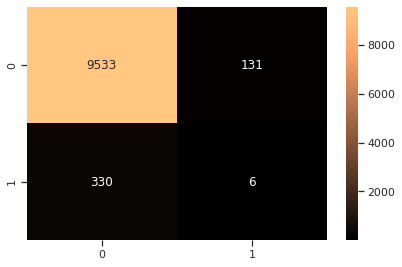

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.500231,0.0178571,0.986445,0.0115746




Additional Info
Total predicted to be positive: 137 

Predicted matches
137 [ 44  52  72 219 230 271 298 336 399 479 487 507 510 511 537 557 558 567
 586 592 604 692 732]

[4928  950  567 8701 7166 1047 7227 7455  905 9258 2532  895 1271  803
 3105 4796  823 5921 8938   72  592 3497  974]

Matched draws
Count: 6, Index: (array([  44,  511,  558, 4613, 6257, 8988]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
        DrawNo   DrawDate   PrizeType  LuckyNo
104571  495419 2019-06-01  SpecialNo1      511
104599  495519 2019-06-02  SpecialNo5      558
104789  496419 2019-06-22  2ndPrizeNo       44


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
104571  495419 2019-06-01      SpecialNo1      511
104599  495519 2019-06-02      SpecialNo5      558
104789  496419 2019-06-22      2ndPrizeNo       44
104798  496419 2019-06-22  ConsolationNo7     8988
104803  496419 2019-06-22      SpecialNo2     6257
104898 

In [26]:
# Predict for a particular month
# %time predict(pd.datetime(2019,6,1), feature_matrix_selection)

#%time gen_train_test_set(pd.datetime(2019,6,1), feature_matrix_selection)

%time model(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='orig')


2019-06-01 00:00:00
-------------------

Training on 889893 observations.
Testing on 10000 observations.

Data shape before balancing: (889893, 62)

Counts of strikes vs non-strikes in previous data:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------

NO balancing
Data shape after balancing: (889893, 62)

Counts of strikes VS non-strikes in new data:
0    860060
1     29833
Name: Label, dtype: int64

NO filtering
CPU times: user 3.85 s, sys: 1.06 s, total: 4.91 s
Wall time: 6.43 s
Data shape
(889893, 61) (889893,) (10000, 61) (10000,)

Calculating scale pos weight
Counter({0: 860060, 1: 29833})

scale_pos_weight - 28.829148929038315

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.95, 'gamma': 0.1, 'learning_rate': 0.007, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 300, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'rand

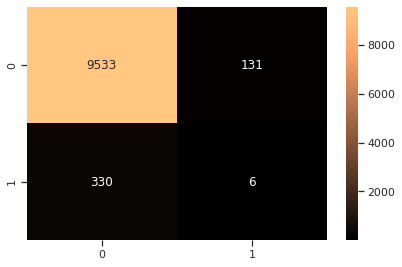

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.500231,0.0178571,0.986445,0.0115746




Additional Info
Total predicted to be positive: 137 

Predicted matches
137 [ 44  52  72 219 230 271 298 336 399 479 487 507 510 511 537 557 558 567
 586 592 604 692 732]

[4928  950  567 8701 7166 1047 7227 7455  905 9258 2532  895 1271  803
 3105 4796  823 5921 8938   72  592 3497  974]

Matched draws
Count: 6, Index: (array([  44,  511,  558, 4613, 6257, 8988]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
        DrawNo   DrawDate   PrizeType  LuckyNo
104571  495419 2019-06-01  SpecialNo1      511
104599  495519 2019-06-02  SpecialNo5      558
104789  496419 2019-06-22  2ndPrizeNo       44


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
104571  495419 2019-06-01      SpecialNo1      511
104599  495519 2019-06-02      SpecialNo5      558
104789  496419 2019-06-22      2ndPrizeNo       44
104798  496419 2019-06-22  ConsolationNo7     8988
104803  496419 2019-06-22      SpecialNo2     6257
104898 

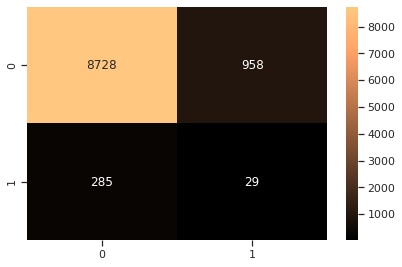

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.499294,0.0923567,0.901094,0.0541042




Additional Info
Total predicted to be positive: 987 

Predicted matches
987 [  0   9  18  28  29  33  38  42  45  49  52  54  64  67  72  75  77  80
  92  96 102 104 107]

[ 197  540 2466  537 4876  897 1009  479  823  974  193 4036  210 7173
  567  557 1018 3340  422  905  903  895  628]

Matched draws
Count: 29, Index: (array([  28,  463,  476,  502,  559,  931, 1093, 1268, 1374, 1618, 1938,
       2117, 2495, 2692, 2787, 3150, 3211, 3664, 3694, 4055, 4371, 4401,
       5618, 5837, 5842, 6550, 6782, 7173, 7436]),)


Top 23 Possibility
        DrawNo   DrawDate       PrizeType  LuckyNo
105029  497419 2019-07-14  ConsolationNo8     7173


First 23 Numbers
        DrawNo   DrawDate   PrizeType  LuckyNo
104996  497319 2019-07-13  2ndPrizeNo       28


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
104953  497119 2019-07-07  ConsolationNo10     5842
104961  497119 2019-07-07   ConsolationNo9     2692
104962  497119 2019-07-07       SpecialNo1     4401
104967  497119 201

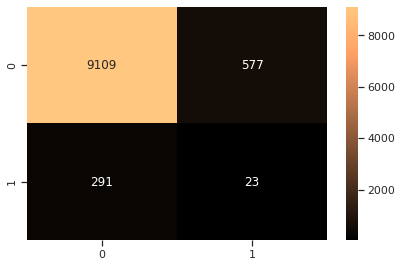

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.501385,0.0732484,0.940429,0.0466846




Additional Info
Total predicted to be positive: 600 

Predicted matches
600 [  2   5  18  28  33  38  42  52  54  72  75  77 111 113 115 117 121 130
 151 163 173 180 184]

[1253  535 1085  905  950  625 1017   38  925  903 5378 1047   28  628
  895  197 1949 1231  823 1989  753 7227 7455]

Matched draws
Count: 23, Index: (array([ 502,  743,  806, 1018, 1064, 1164, 1217, 2059, 2075, 2205, 2492,
       2983, 3340, 4675, 4704, 4876, 5051, 5378, 6510, 6742, 7292, 7466,
       9150]),)


Top 23 Possibility
        DrawNo   DrawDate   PrizeType  LuckyNo
105291  498519 2019-08-07  SpecialNo7     5378


First 23 Numbers
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
105244  498319 2019-08-03       SpecialNo6     9150
105277  498519 2019-08-07   ConsolationNo3     5051
105286  498519 2019-08-07       SpecialNo2     4675
105291  498519 2019-08-07       SpecialNo7     5378
105303  498619 2019-08-10   Co

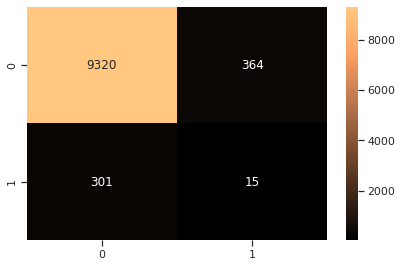

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.500237,0.0474684,0.962412,0.0304571




Additional Info
Total predicted to be positive: 379 

Predicted matches
379 [ 11  28  38  42  65  72 110 121 177 184 193 197 203 220 258 282 283 295
 298 315 380 384 385]

[1047 7202 7889 7402 1989 2479 3591 9765 8981 6114 1271 5311  950 7455
 2393  823 7836 5704  743 2037 5378 1949  905]

Matched draws
Count: 15, Index: (array([  28,  732,  851,  905, 1089, 1504, 2188, 2672, 3470, 3591, 5921,
       7931, 8981, 9763, 9865]),)


Top 23 Possibility
        DrawNo   DrawDate   PrizeType  LuckyNo
105614  499919 2019-09-07  SpecialNo8     8981
105632  500019 2019-09-08  SpecialNo3      905
105687  500319 2019-09-14  3rdPrizeNo     3591
105862  501019 2019-09-29  SpecialNo3      905


First 23 Numbers
        DrawNo   DrawDate   PrizeType  LuckyNo
105617  500019 2019-09-08  2ndPrizeNo       28


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
105557  499719 2019-09-01  ConsolationNo7      851
105592  499819 2019-09-04      SpecialNo9     3470
105609  499919 2019-09-07      

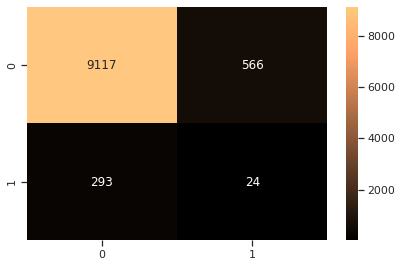

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.499504,0.0757098,0.941547,0.0488772




Additional Info
Total predicted to be positive: 590 

Predicted matches
590 [ 18  28  33  38  52  54  72 107 113 115 121 177 184 193 197 203 210 216
 219 220 225 226 230]

[ 184 1828 7402 4609 7227 1271 4465  925 5311 6114 8690 8981 2479 5378
 1949 5301 4562  905 7455 3591  823  950 9258]

Matched draws
Count: 24, Index: (array([  38,  305,  540,  556,  619,  639,  823,  841, 1301, 1372, 2171,
       2188, 2227, 2330, 3300, 3883, 4060, 4268, 4928, 5191, 5378, 6557,
       6977, 8140]),)


Top 23 Possibility
        DrawNo   DrawDate       PrizeType  LuckyNo
106003  501619 2019-10-12      SpecialNo6      823
106087  502019 2019-10-20  ConsolationNo8     5378


First 23 Numbers
        DrawNo   DrawDate    PrizeType  LuckyNo
106182  502419 2019-10-30  SpecialNo10       38


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
105902  501219 2019-10-02  ConsolationNo7      556
105916  501319 2019-10-05      2ndPrizeNo     4928
105920  501319 2019-10-05  ConsolationNo2     4060

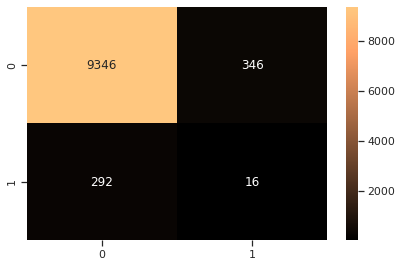

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.499057,0.0519481,0.9643,0.0344185




Additional Info
Total predicted to be positive: 362 

Predicted matches
362 [ 18  19  28  33  42  54  72 102 107 113 115 184 193 197 203 210 219 220
 226 240 243 249 283]

[3114 1949 4562 9765 7836  592 7227 5301 9258 5311  905  823 5378 8938
 2479 1124 6114 1933 3591 7455 8981  950  407]

Matched draws
Count: 16, Index: (array([ 249,  536,  559,  595,  622,  753,  897, 1043, 1289, 3515, 4465,
       4647, 5080, 7181, 7539, 9020]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
        DrawNo   DrawDate       PrizeType  LuckyNo
106197  502519 2019-11-02  ConsolationNo3      249


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
106191  502519 2019-11-02       1stPrizeNo      753
106197  502519 2019-11-02   ConsolationNo3      249
106203  502519 2019-11-02   ConsolationNo9      536
106228  502619 2019-11-03      SpecialNo10     1043
106258  502719 2019-11-05       SpecialNo8      897
106267  502819 2019

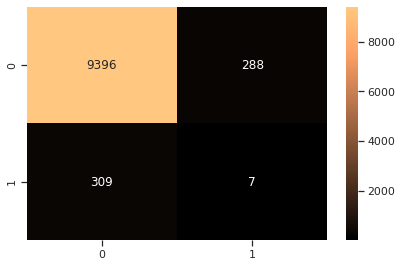

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.5007,0.0221519,0.97026,0.0117736




Additional Info
Total predicted to be positive: 295 

Predicted matches
295 [ 19  33  35  54  72 102 113 185 193 199 210 216 219 220 226 271 283 298
 315 317 363 384 392]

[4609 4562 1271   19  592 9258  905 1949 8690 7586 7227 3591 5311  823
 5378 7455 7836 5301  950 4465 8981 2479 8938]

Matched draws
Count: 7, Index: (array([ 572,  622,  708, 1082, 2213, 3497, 4267]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
106525  503919 2019-12-01  ConsolationNo9      572
106539  504019 2019-12-03  ConsolationNo1     3497
106560  504119 2019-12-04      2ndPrizeNo     2213
106595  504219 2019-12-07      SpecialNo1      622
106653  504519 2019-12-14      3rdPrizeNo      708
106803  505119 2019-12-28     SpecialNo10     4267
106810  505119 2019-12-28      SpecialNo8     1082
CPU times: us

In [27]:
start_mt = pd.datetime(2019,6,1)
how_many_mt = 7 
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")
  %time gen_train_test_set(month_to_predict, feature_matrix_selection, file_prefix='test')
  %time model(month_to_predict, feature_matrix_selection, file_prefix='test')

Data shape
(889893, 61) (889893,) (10000, 61) (10000,)

Calculating scale pos weight
Counter({0: 860060, 1: 29833})

scale_pos_weight - 28.829148929038315

{'base_score': 0.5, 'booster': 'dart', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.95, 'gamma': 0.1, 'learning_rate': 0.007, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 300, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 28.829148929038315, 'seed': None, 'silent': None, 'subsample': 0.55, 'verbosity': 1, 'tree_method': 'hist'}
Parameter distribution: {'n_estimators': [100, 300, 500, 800, 1000], 'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2), 'subsample': [0.55, 0.6, 0.65], 'colsample_bytree': [0.85, 0.9, 0.95], 'scale_pos_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,

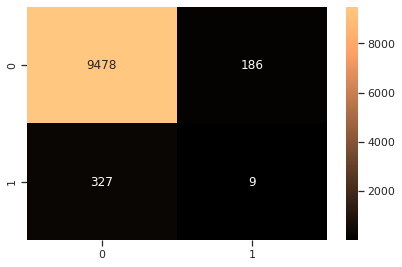

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.500331,0.0267857,0.980753,0.0175792




Additional Info
Total predicted to be positive: 195 

Predicted matches
195 [  6  44  52  72 197 217 219 230 279 283 298 356 392 422 463 468 479 487
 507 510 520 537 540]

[4036  298  974 1553 1686 5311 7983 1047  903 4851 1671  595 4060  510
  823 1009  803 4267  706  479  487  230  661]

Matched draws
Count: 9, Index: (array([   6,   44,  217,  628,  994, 4663, 5501, 6257, 8988]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
        DrawNo   DrawDate       PrizeType  LuckyNo
104635  495719 2019-06-08  ConsolationNo5        6
104789  496419 2019-06-22      2ndPrizeNo       44
104844  496619 2019-06-26  ConsolationNo7      217
104856  496619 2019-06-26      SpecialNo9        6


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
104635  495719 2019-06-08  ConsolationNo5        6
104789  496419 2019-06-22      2ndPrizeNo       44
104798  496419 2019-06-22  ConsolationNo7     8988
104803  496419 2019-06-2

In [30]:
# booster = 'dart'
%time model(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='orig')

Data shape
(889893, 61) (889893,) (10000, 61) (10000,)

Calculating scale pos weight
Counter({0: 860060, 1: 29833})

scale_pos_weight - 28.829148929038315

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.95, 'gamma': 0.1, 'learning_rate': 0.007, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 400, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 28.829148929038315, 'seed': None, 'silent': None, 'subsample': 0.55, 'verbosity': 1, 'tree_method': 'hist'}
Parameter distribution: {'n_estimators': [100, 300, 500, 800, 1000], 'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2), 'subsample': [0.55, 0.6, 0.65], 'colsample_bytree': [0.85, 0.9, 0.95], 'scale_pos_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3

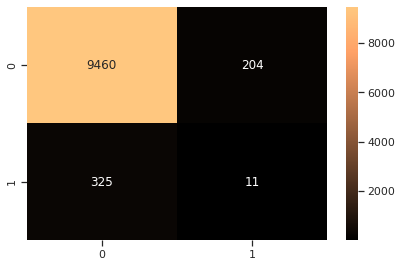

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.499813,0.0327381,0.978891,0.0219686




Additional Info
Total predicted to be positive: 215 

Predicted matches
215 [ 44  52  72 197 219 230 271 285 298 322 336 399 479 487 507 510 511 537
 557 558 567 586 592]

[5842 7181  803  974   72 2107 8701 5311 7166  557  592 4928  479  905
 3105 1047  895 7227 1271  823 5921 7455 8938]

Matched draws
Count: 11, Index: (array([  44,  511,  558,  767,  994, 2169, 4613, 6257, 6430, 6894, 8988]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
        DrawNo   DrawDate   PrizeType  LuckyNo
104571  495419 2019-06-01  SpecialNo1      511
104599  495519 2019-06-02  SpecialNo5      558
104789  496419 2019-06-22  2ndPrizeNo       44


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
104571  495419 2019-06-01      SpecialNo1      511
104597  495519 2019-06-02      SpecialNo3      767
104599  495519 2019-06-02      SpecialNo5      558
104633  495719 2019-06-08  ConsolationNo3     6894
104783  496319 2019-06-19  

In [32]:
# n_estimators = 400
%time model(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='orig')


2019-06-01 00:00:00
-------------------

Training on 889893 observations.
Testing on 10000 observations.

Data shape before balancing: (889893, 62)

Counts of strikes vs non-strikes in previous data:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------

NO balancing
Data shape after balancing: (889893, 62)

Counts of strikes VS non-strikes in new data:
0    860060
1     29833
Name: Label, dtype: int64

NO filtering
CPU times: user 4.41 s, sys: 770 ms, total: 5.18 s
Wall time: 6.52 s
Data shape
(889893, 61) (889893,) (10000, 61) (10000,)

Calculating scale pos weight
Counter({0: 860060, 1: 29833})

scale_pos_weight - 28.829148929038315

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.95, 'gamma': 0.1, 'learning_rate': 0.007, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 400, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'rand

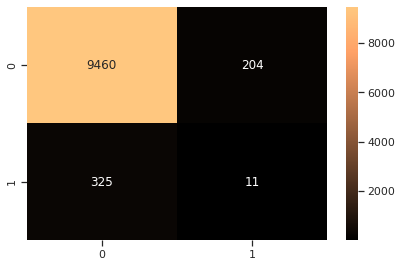

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.499813,0.0327381,0.978891,0.0219686




Additional Info
Total predicted to be positive: 215 

Predicted matches
215 [ 44  52  72 197 219 230 271 285 298 322 336 399 479 487 507 510 511 537
 557 558 567 586 592]

[5842 7181  803  974   72 2107 8701 5311 7166  557  592 4928  479  905
 3105 1047  895 7227 1271  823 5921 7455 8938]

Matched draws
Count: 11, Index: (array([  44,  511,  558,  767,  994, 2169, 4613, 6257, 6430, 6894, 8988]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
        DrawNo   DrawDate   PrizeType  LuckyNo
104571  495419 2019-06-01  SpecialNo1      511
104599  495519 2019-06-02  SpecialNo5      558
104789  496419 2019-06-22  2ndPrizeNo       44


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
104571  495419 2019-06-01      SpecialNo1      511
104597  495519 2019-06-02      SpecialNo3      767
104599  495519 2019-06-02      SpecialNo5      558
104633  495719 2019-06-08  ConsolationNo3     6894
104783  496319 2019-06-19  

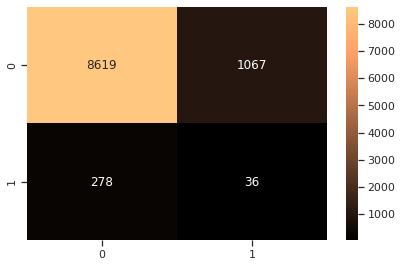

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.500228,0.11465,0.889841,0.0696879




Additional Info
Total predicted to be positive: 1103 

Predicted matches
1103 [  0   5   6   9  18  19  28  29  33  38  45  49  50  52  54  64  66  67
  72  75  77  80 104]

[4876 3340  210 6772  895  903  905  628  974 1009  479  823 1018  537
  422  298 1115  595  557 2466 1671  567  193]

Matched draws
Count: 36, Index: (array([  28,   66,  463,  476,  502,  559,  931, 1085, 1093, 1268, 1374,
       1583, 1618, 1938, 2117, 2381, 2495, 2692, 2787, 3150, 3211, 3664,
       3694, 4055, 4371, 4401, 5618, 5702, 5837, 5842, 6550, 6782, 7173,
       7436, 8506, 8556]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
        DrawNo   DrawDate       PrizeType  LuckyNo
104996  497319 2019-07-13      2ndPrizeNo       28
105186  498119 2019-07-30  ConsolationNo4       66


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
104953  497119 2019-07-07  ConsolationNo10     5842
104961  497119 2019-07-07   ConsolationN

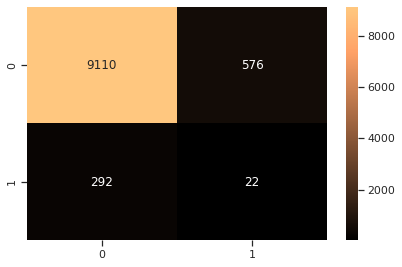

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.500828,0.0700637,0.940533,0.0441575




Additional Info
Total predicted to be positive: 598 

Predicted matches
598 [  2   5  16  18  28  33  38  52  54  72 111 113 115 117 121 151 163 180
 184 191 193 197 201]

[7227 5378  535 1253 7844  479  823 1047 7402   38  905 1989  903   28
 2335  925  895 7455  950  197 1231  753  628]

Matched draws
Count: 22, Index: (array([ 502,  743,  806,  845, 1018, 1064, 1164, 1217, 2075, 2082, 2205,
       2492, 2983, 3340, 4675, 4704, 4876, 5051, 5378, 6510, 7466, 9150]),)


Top 23 Possibility
        DrawNo   DrawDate   PrizeType  LuckyNo
105291  498519 2019-08-07  SpecialNo7     5378


First 23 Numbers
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
105244  498319 2019-08-03       SpecialNo6     9150
105277  498519 2019-08-07   ConsolationNo3     5051
105286  498519 2019-08-07       SpecialNo2     4675
105291  498519 2019-08-07       SpecialNo7     5378
105303  498619 2019-08-10   ConsolationNo6 

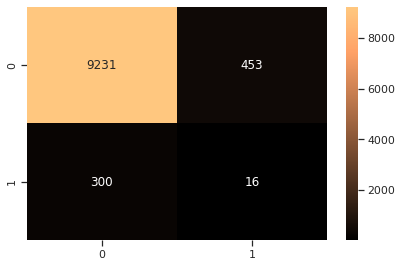

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.500831,0.0506329,0.953222,0.0311507




Additional Info
Total predicted to be positive: 469 

Predicted matches
469 [ 11  28  38  52  65  72  88 110 121 163 176 177 181 184 193 197 203 220
 240 258 272 279 282]

[1047 2037 9765 4116 1989 2393 5704 9963 8690 7836 7455  950 1949 6114
  905 2479 3591  823 5311  743 8981 5378 1271]

Matched draws
Count: 16, Index: (array([  28,  732,  851,  905, 1089, 1504, 1828, 2188, 2672, 3470, 3591,
       3612, 5533, 5921, 7931, 8981]),)


Top 23 Possibility
        DrawNo   DrawDate   PrizeType  LuckyNo
105614  499919 2019-09-07  SpecialNo8     8981
105632  500019 2019-09-08  SpecialNo3      905
105687  500319 2019-09-14  3rdPrizeNo     3591
105862  501019 2019-09-29  SpecialNo3      905


First 23 Numbers
        DrawNo   DrawDate   PrizeType  LuckyNo
105617  500019 2019-09-08  2ndPrizeNo       28


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
105557  499719 2019-09-01  ConsolationNo7      851
105592  499819 2019-09-04      SpecialNo9     3470
105614  499919 2019-09-07

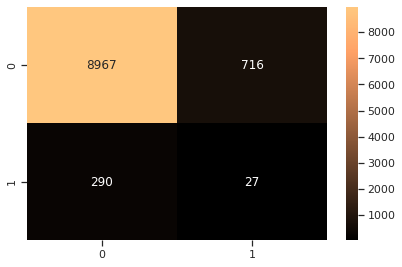

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.499251,0.0851735,0.926056,0.05335




Additional Info
Total predicted to be positive: 743 

Predicted matches
743 [  5  18  19  28  33  38  42  50  52  54  67  72 102 107 113 115 121 151
 152 163 177 184 193]

[1989 6326 7227 4465 1271  184  925 1949  905 6114 5301 9258 5378 3591
 5311 2479 7455 7402  823  950 8981 8690 4562]

Matched draws
Count: 27, Index: (array([  38,  305,  540,  556,  619,  639,  823,  841,  910, 1301, 1372,
       1813, 2171, 2188, 2227, 2330, 3300, 3620, 3883, 4060, 4268, 4928,
       5191, 5378, 6557, 6977, 8140]),)


Top 23 Possibility
        DrawNo   DrawDate       PrizeType  LuckyNo
106003  501619 2019-10-12      SpecialNo6      823
106087  502019 2019-10-20  ConsolationNo8     5378


First 23 Numbers
        DrawNo   DrawDate    PrizeType  LuckyNo
106182  502419 2019-10-30  SpecialNo10       38


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
105902  501219 2019-10-02  ConsolationNo7      556
105916  501319 2019-10-05      2ndPrizeNo     4928
105920  501319 2019-10-05  Conso

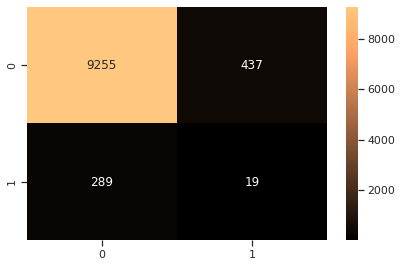

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.499459,0.0616883,0.954911,0.0403329




Additional Info
Total predicted to be positive: 456 

Predicted matches
456 [ 18  19  28  33  42  54  72 102 107 113 184 193 197 210 216 219 220 226
 229 230 240 279 283]

[6114 7227 7836 1271  592 4562 7139 2479 1933  905 6326 5311 8938  823
 5378 3591 7455 8981  950 5301 9258 1124  407]

Matched draws
Count: 19, Index: (array([ 436,  536,  559,  595,  622,  753,  897, 1043, 1052, 1457, 3515,
       3778, 4465, 4647, 5080, 7181, 7444, 7539, 9020]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
106191  502519 2019-11-02       1stPrizeNo      753
106203  502519 2019-11-02   ConsolationNo9      536
106228  502619 2019-11-03      SpecialNo10     1043
106238  502719 2019-11-05       2ndPrizeNo     7444
106244  502719 2019-11-05   ConsolationNo4     1052
106258  502719 2019-11-05    

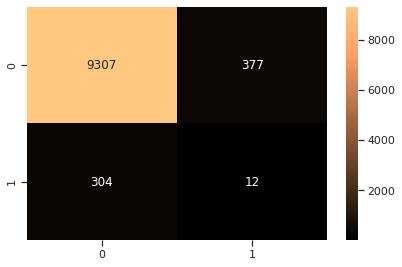

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.50074,0.0379747,0.96107,0.0225937




Additional Info
Total predicted to be positive: 389 

Predicted matches
389 [ 19  42  54  72 102 113 193 199 210 216 219 220 226 230 249 271 279 283
 295 298 315 344 363]

[1271 6114 6326 3591 9258 1989 9963  905  823  592 5311 1949 7227 2479
 8690 5378 8938 5301 8981 7455 7836  950 4465]

Matched draws
Count: 12, Index: (array([ 559,  572,  594,  622,  708, 1082, 2213, 3098, 3497, 4267, 4709,
       5629]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
106516  503919 2019-12-01  ConsolationNo1     3098
106525  503919 2019-12-01  ConsolationNo9      572
106539  504019 2019-12-03  ConsolationNo1     3497
106560  504119 2019-12-04      2ndPrizeNo     2213
106595  504219 2019-12-07      SpecialNo1      622
106612  504319 2019-12-08  ConsolationNo4     4709
106644  504419 2019-12-11 

In [33]:
# n_estimators = 400
start_mt = pd.datetime(2019,6,1)
how_many_mt = 7 
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")
  %time gen_train_test_set(month_to_predict, feature_matrix_selection, file_prefix='test')
  %time model(month_to_predict, feature_matrix_selection, file_prefix='test')

In [0]:
# n_estimators = 300
# remove outlier
# filter features
start_mt = pd.datetime(2019,6,1)
how_many_mt = 7 
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")
  %time gen_train_test_set(month_to_predict, feature_matrix_selection, file_prefix='test')
  %time model(month_to_predict, feature_matrix_selection, file_prefix='test')


2019-06-01 00:00:00
-------------------

Training on 889893 observations.
Testing on 10000 observations.

Data shape before balancing: (889893, 62)

Counts of strikes vs non-strikes in previous data:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------

NO balancing
Data shape after balancing: (889893, 62)

Counts of strikes VS non-strikes in new data:
0    860060
1     29833
Name: Label, dtype: int64
